# CSE 6363 - Assignment 4: Deep Learning
# Ty Buchanan

# Part 1: Q-Learning and Policy Iteration on the Frozen Lake Environment
### Q-Learning Algorithm

In [37]:
# Author: Andrea Pierré
# License: MIT License


from pathlib import Path
from typing import NamedTuple

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from tqdm import tqdm

import gymnasium as gym
from gymnasium.envs.toy_text.frozen_lake import generate_random_map


sns.set_theme()

# %load_ext lab_black

In [38]:
class Params(NamedTuple):
    total_episodes: int  # Total episodes
    learning_rate: float  # Learning rate
    gamma: float  # Discounting rate
    epsilon: float  # Exploration probability
    map_size: int  # Number of tiles of one side of the squared environment
    seed: int  # Define a seed so that we get reproducible results
    is_slippery: bool  # If true the player will move in intended direction with probability of 1/3 else will move in either perpendicular direction with equal probability of 1/3 in both directions
    n_runs: int  # Number of runs
    action_size: int  # Number of possible actions
    state_size: int  # Number of possible states
    proba_frozen: float  # Probability that a tile is frozen
    savefig_folder: Path  # Root folder where plots are saved


params = Params(
    total_episodes=2000,
    learning_rate=0.8,
    gamma=0.95,
    epsilon=0.1,
    map_size=5,
    seed=123,
    is_slippery=False,
    n_runs=20,
    action_size=None,
    state_size=None,
    proba_frozen=0.9,
    savefig_folder=Path("../../_static/img/tutorials/"),
)
params

# Set the seed
rng = np.random.default_rng(params.seed)

# Create the figure folder if it doesn't exist
params.savefig_folder.mkdir(parents=True, exist_ok=True)

In [39]:
env = gym.make(
    "FrozenLake-v1",
    is_slippery=params.is_slippery,
    render_mode="rgb_array",
    desc=generate_random_map(
        size=params.map_size, p=params.proba_frozen, seed=params.seed
    ),
)

In [40]:
params = params._replace(action_size=env.action_space.n)
params = params._replace(state_size=env.observation_space.n)
print(f"Action size: {params.action_size}")
print(f"State size: {params.state_size}")


class Qlearning:
    def __init__(self, learning_rate, gamma, state_size, action_size):
        self.state_size = state_size
        self.action_size = action_size
        self.learning_rate = learning_rate
        self.gamma = gamma
        self.reset_qtable()

    def update(self, state, action, reward, new_state):
        """Update Q(s,a):= Q(s,a) + lr [R(s,a) + gamma * max Q(s',a') - Q(s,a)]"""
        delta = (
            reward
            + self.gamma * np.max(self.qtable[new_state, :])
            - self.qtable[state, action]
        )
        q_update = self.qtable[state, action] + self.learning_rate * delta
        return q_update

    def reset_qtable(self):
        """Reset the Q-table."""
        self.qtable = np.zeros((self.state_size, self.action_size))


class EpsilonGreedy:
    def __init__(self, epsilon):
        self.epsilon = epsilon

    def choose_action(self, action_space, state, qtable):
        """Choose an action `a` in the current world state (s)."""
        # First we randomize a number
        explor_exploit_tradeoff = rng.uniform(0, 1)

        # Exploration
        if explor_exploit_tradeoff < self.epsilon:
            action = action_space.sample()

        # Exploitation (taking the biggest Q-value for this state)
        else:
            # Break ties randomly
            # Find the indices where the Q-value equals the maximum value
            # Choose a random action from the indices where the Q-value is maximum
            max_ids = np.where(qtable[state, :] == max(qtable[state, :]))[0]
            action = rng.choice(max_ids)
        return action

Action size: 4
State size: 25


In [41]:
learner = Qlearning(
    learning_rate=params.learning_rate,
    gamma=params.gamma,
    state_size=params.state_size,
    action_size=params.action_size,
)
explorer = EpsilonGreedy(
    epsilon=params.epsilon,
)

In [42]:
def run_env():
    rewards = np.zeros((params.total_episodes, params.n_runs))
    steps = np.zeros((params.total_episodes, params.n_runs))
    episodes = np.arange(params.total_episodes)
    qtables = np.zeros((params.n_runs, params.state_size, params.action_size))
    all_states = []
    all_actions = []

    for run in range(params.n_runs):  # Run several times to account for stochasticity
        learner.reset_qtable()  # Reset the Q-table between runs

        for episode in tqdm(
            episodes, desc=f"Run {run}/{params.n_runs} - Episodes", leave=False
        ):
            state = env.reset(seed=params.seed)[0]  # Reset the environment
            step = 0
            done = False
            total_rewards = 0

            while not done:
                action = explorer.choose_action(
                    action_space=env.action_space, state=state, qtable=learner.qtable
                )

                # Log all states and actions
                all_states.append(state)
                all_actions.append(action)

                # Take the action (a) and observe the outcome state(s') and reward (r)
                new_state, reward, terminated, truncated, info = env.step(action)

                done = terminated or truncated

                learner.qtable[state, action] = learner.update(
                    state, action, reward, new_state
                )

                total_rewards += reward
                step += 1

                # Our new state is state
                state = new_state

            # Log all rewards and steps
            rewards[episode, run] = total_rewards
            steps[episode, run] = step
        qtables[run, :, :] = learner.qtable

    return rewards, steps, episodes, qtables, all_states, all_actions

In [43]:
def postprocess(episodes, params, rewards, steps, map_size):
    """Convert the results of the simulation in dataframes."""
    res = pd.DataFrame(
        data={
            "Episodes": np.tile(episodes, reps=params.n_runs),
            "Rewards": rewards.flatten(order="F"),
            "Steps": steps.flatten(order="F"),
        }
    )
    res["cum_rewards"] = rewards.cumsum(axis=0).flatten(order="F")
    res["map_size"] = np.repeat(f"{map_size}x{map_size}", res.shape[0])

    st = pd.DataFrame(data={"Episodes": episodes, "Steps": steps.mean(axis=1)})
    st["map_size"] = np.repeat(f"{map_size}x{map_size}", st.shape[0])
    return res, st

In [44]:
def qtable_directions_map(qtable, map_size):
    """Get the best learned action & map it to arrows."""
    qtable_val_max = qtable.max(axis=1).reshape(map_size, map_size)
    qtable_best_action = np.argmax(qtable, axis=1).reshape(map_size, map_size)
    directions = {0: "←", 1: "↓", 2: "→", 3: "↑"}
    qtable_directions = np.empty(qtable_best_action.flatten().shape, dtype=str)
    eps = np.finfo(float).eps  # Minimum float number on the machine
    for idx, val in enumerate(qtable_best_action.flatten()):
        if qtable_val_max.flatten()[idx] > eps:
            # Assign an arrow only if a minimal Q-value has been learned as best action
            # otherwise since 0 is a direction, it also gets mapped on the tiles where
            # it didn't actually learn anything
            qtable_directions[idx] = directions[val]
    qtable_directions = qtable_directions.reshape(map_size, map_size)
    return qtable_val_max, qtable_directions

In [45]:
def plot_q_values_map(qtable, env, map_size):
    """Plot the last frame of the simulation and the policy learned."""
    qtable_val_max, qtable_directions = qtable_directions_map(qtable, map_size)

    # Plot the last frame
    fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(15, 5))
    ax[0].imshow(env.render())
    ax[0].axis("off")
    ax[0].set_title("Last frame")

    # Plot the policy
    sns.heatmap(
        qtable_val_max,
        annot=qtable_directions,
        fmt="",
        ax=ax[1],
        cmap=sns.color_palette("Blues", as_cmap=True),
        linewidths=0.7,
        linecolor="black",
        xticklabels=[],
        yticklabels=[],
        annot_kws={"fontsize": "xx-large"},
    ).set(title="Learned Q-values\nArrows represent best action")
    for _, spine in ax[1].spines.items():
        spine.set_visible(True)
        spine.set_linewidth(0.7)
        spine.set_color("black")
    img_title = f"frozenlake_q_values_{map_size}x{map_size}.png"
    fig.savefig(params.savefig_folder / img_title, bbox_inches="tight")
    plt.show()

In [46]:
def plot_states_actions_distribution(states, actions, map_size):
    """Plot the distributions of states and actions."""
    labels = {"LEFT": 0, "DOWN": 1, "RIGHT": 2, "UP": 3}

    fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(15, 5))
    sns.histplot(data=states, ax=ax[0], kde=True)
    ax[0].set_title("States")
    sns.histplot(data=actions, ax=ax[1])
    ax[1].set_xticks(list(labels.values()), labels=labels.keys())
    ax[1].set_title("Actions")
    fig.tight_layout()
    img_title = f"frozenlake_states_actions_distrib_{map_size}x{map_size}.png"
    fig.savefig(params.savefig_folder / img_title, bbox_inches="tight")
    plt.show()

Map size: 4x4


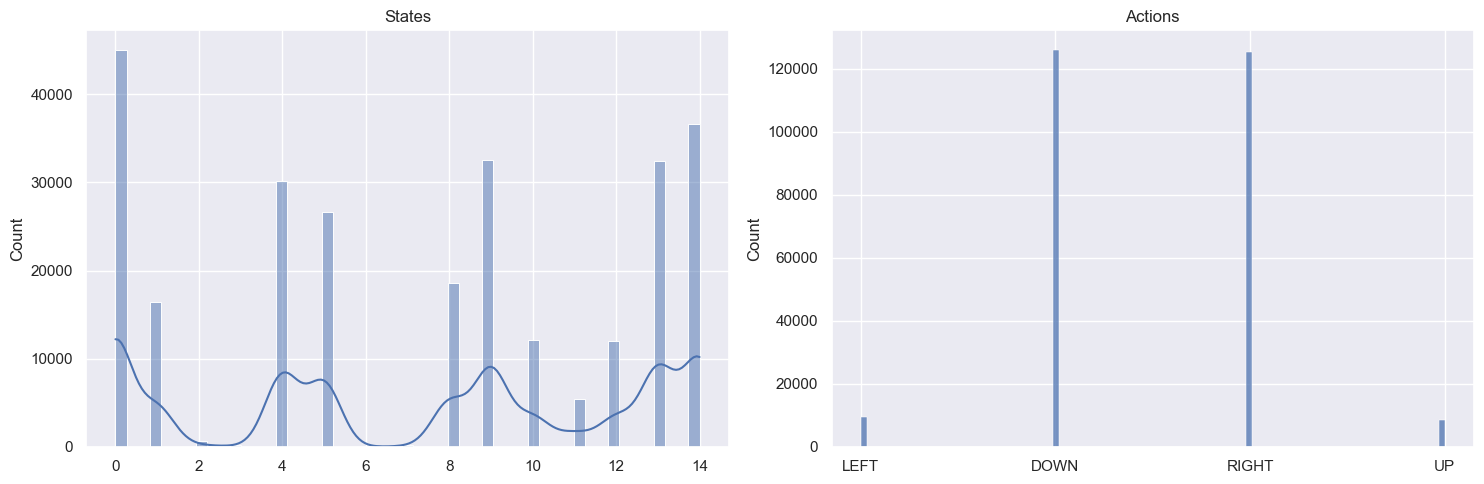

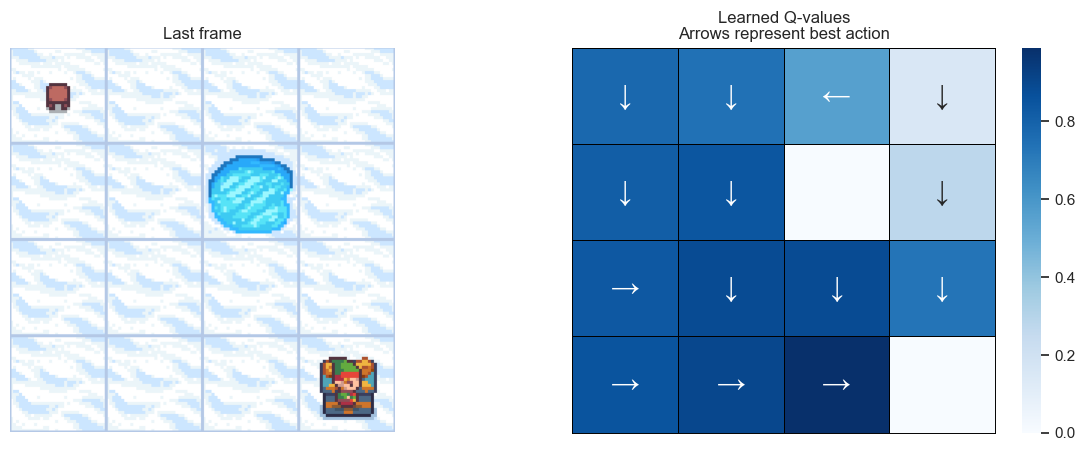

In [136]:
map_sizes = [4]
res_all = pd.DataFrame()
st_all = pd.DataFrame()

for map_size in map_sizes:
    env = gym.make(
        "FrozenLake-v1",
        is_slippery=params.is_slippery,
        render_mode="rgb_array",
        desc=generate_random_map(
            size=map_size, p=params.proba_frozen, seed=params.seed
        ),
    )

    params = params._replace(action_size=env.action_space.n)
    params = params._replace(state_size=env.observation_space.n)
    env.action_space.seed(
        params.seed
    )  # Set the seed to get reproducible results when sampling the action space
    learner = Qlearning(
        learning_rate=params.learning_rate,
        gamma=params.gamma,
        state_size=params.state_size,
        action_size=params.action_size,
    )
    explorer = EpsilonGreedy(
        epsilon=params.epsilon,
    )

    print(f"Map size: {map_size}x{map_size}")
    rewards, steps, episodes, qtables, all_states, all_actions = run_env()

    # Save the results in dataframes
    res, st = postprocess(episodes, params, rewards, steps, map_size)
    res_all = pd.concat([res_all, res])
    st_all = pd.concat([st_all, st])
    qtable = qtables.mean(axis=0)  # Average the Q-table between runs

    plot_states_actions_distribution(
        states=all_states, actions=all_actions, map_size=map_size
    )  # Sanity check
    plot_q_values_map(qtable, env, map_size)

    env.close()

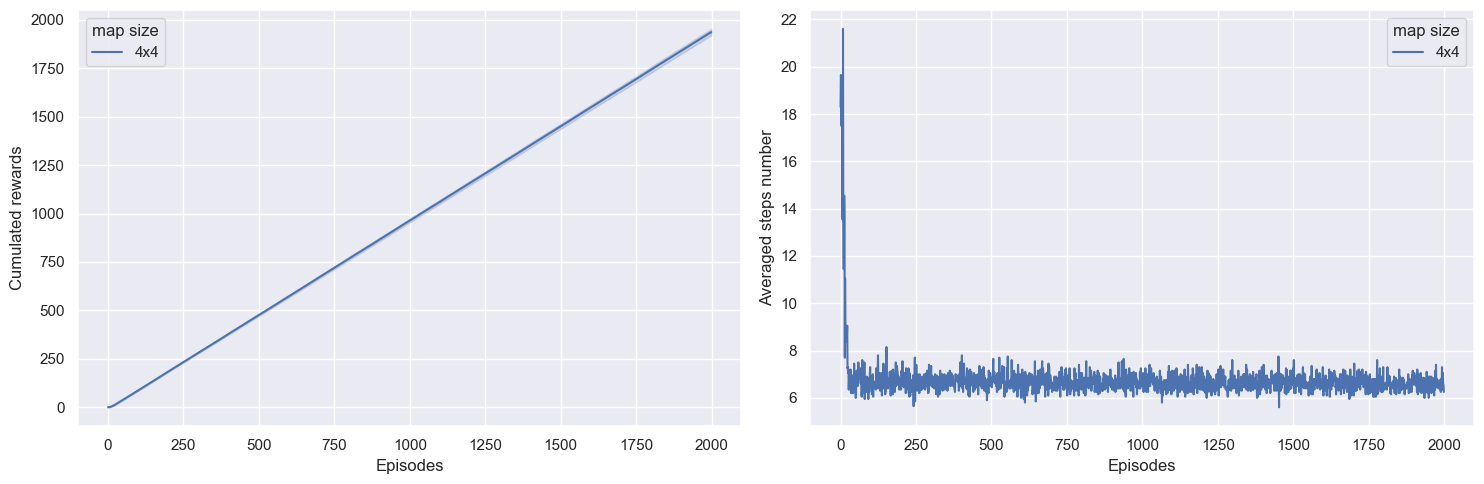

In [137]:
def plot_steps_and_rewards(rewards_df, steps_df):
    """Plot the steps and rewards from dataframes."""
    fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(15, 5))
    sns.lineplot(
        data=rewards_df, x="Episodes", y="cum_rewards", hue="map_size", ax=ax[0]
    )
    ax[0].set(ylabel="Cumulated rewards")

    sns.lineplot(data=steps_df, x="Episodes", y="Steps", hue="map_size", ax=ax[1])
    ax[1].set(ylabel="Averaged steps number")

    for axi in ax:
        axi.legend(title="map size")
    fig.tight_layout()
    img_title = "frozenlake_steps_and_rewards.png"
    fig.savefig(params.savefig_folder / img_title, bbox_inches="tight")
    plt.show()


plot_steps_and_rewards(res_all, st_all)

# Part 1: Q-Learning and Policy Iteration on the Frozen Lake Environment
### Policy Iteration Algorithm

In [138]:
import numpy as np
import gymnasium as gym

def policy_evaluation(env, policy, gamma=0.99, theta=1e-8):
    V = np.zeros(env.observation_space.n)
    while True:
        delta = 0
        for state in range(env.observation_space.n):
            v = 0
            for action, action_prob in enumerate(policy[state]):
                for prob, next_state, reward, terminated in env.P[state][action]:
                    v += action_prob * prob * (reward + gamma * V[next_state])
            delta = max(delta, np.abs(v - V[state]))
            V[state] = v
        if delta < 1e-6:
            break
    return V

def policy_improvement(env, V, gamma=0.99):
    policy = np.zeros((env.observation_space.n, env.action_space.n))
    for state in range(env.observation_space.n):
        Q_values = np.zeros(env.action_space.n)
        for action in range(env.action_space.n):
            for prob, next_state, reward, terminated in env.P[state][action]:
                Q_values[action] += prob * (reward + gamma * V[next_state])
        best_action = np.argmax(Q_values)
        policy[state] = np.eye(env.action_space.n)[best_action]
    return policy

def policy_iteration(env, gamma=0.99):
    policy = np.ones((env.observation_space.n, env.action_space.n)) / env.action_space.n
    while True:
        V = policy_evaluation(env, policy, gamma)
        new_policy = policy_improvement(env, V, gamma)
        if np.array_equal(policy, new_policy):
            break
        policy = new_policy
    return policy, V  # <-- Return BOTH policy and V

env = gym.make("FrozenLake-v1", is_slippery=True)
env = env.unwrapped  # Important fix!

optimal_policy, optimal_V = policy_iteration(env)
optimal_actions = np.argmax(optimal_policy, axis=1)
print("Optimal actions per state:")
print(optimal_actions.reshape(4,4))



Optimal actions per state:
[[0 3 3 3]
 [0 0 0 0]
 [3 1 0 0]
 [0 2 1 0]]


In [153]:
import numpy as np

def evaluate_policy(env, optimal_actions, episodes=1000, max_steps=100):
    success = 0
    for episode in range(episodes):
        state, _ = env.reset()
        done = False

        for step in range(max_steps):
            action = optimal_actions[state]
            next_state, reward, terminated, truncated, _ = env.step(action)
            done = terminated or truncated
            if done:
                if reward == 1.0:
                    success += 1
                break
            state = next_state

    success_rate = success / episodes
    print(f"Policy success rate over {episodes} episodes: {success_rate * 100:.2f}%")

# Evaluate your optimal policy practically
evaluate_policy(env, optimal_actions)


Policy success rate over 1000 episodes: 0.00%


In [154]:
# Suppose you already trained a Q-learning agent with Q-table:
qtable  # shape: [states, actions]

# Extract actions from the Q-table
q_learning_actions = np.argmax(qtable, axis=1)

# Evaluate Q-learning policy practically
evaluate_policy(env, q_learning_actions)


Policy success rate over 1000 episodes: 0.00%


In [148]:
import gymnasium as gym
import numpy as np

def train_qlearning(env, alpha, gamma, epsilon, epsilon_decay, epsilon_min, episodes=10000):
    qtable = np.zeros((env.observation_space.n, env.action_space.n))

    for episode in range(episodes):
        state, _ = env.reset()
        terminated, truncated = False, False

        while not (terminated or truncated):
            if np.random.random() < epsilon:
                action = env.action_space.sample()
            else:
                action = np.argmax(qtable[state])

            next_state, reward, terminated, truncated, _ = env.step(action)

            qtable[state, action] += alpha * (
                reward + gamma * np.max(qtable[next_state]) - qtable[state, action]
            )

            state = next_state

        epsilon = max(epsilon_min, epsilon * epsilon_decay)

    return qtable

env = gym.make('FrozenLake-v1', is_slippery=True)

alphas = [0.1, 0.5, 0.9]
gammas = [0.8, 0.9, 0.99]
epsilons = [0.3, 0.1, 0.01]

episodes = 10000
epsilon_decay = 0.999
epsilon_min = 0.01

# Experiment clearly with alpha
for alpha in alphas:
    qtable = train_qlearning(env, alpha=alpha, gamma=0.99, epsilon=1.0, 
                             epsilon_decay=epsilon_decay, epsilon_min=epsilon_min, episodes=episodes)
    optimal_actions = np.argmax(qtable, axis=1)
    print(f"Evaluating alpha={alpha}")
    evaluate_policy(env, optimal_actions)

# Experiment clearly with gamma
for gamma in gammas:
    qtable = train_qlearning(env, alpha=0.1, gamma=gamma, epsilon=1.0, 
                             epsilon_decay=epsilon_decay, epsilon_min=epsilon_min, episodes=episodes)
    optimal_actions = np.argmax(qtable, axis=1)
    print(f"Evaluating gamma={gamma}")
    evaluate_policy(env, optimal_actions)

# Experiment clearly with epsilon (initial exploration rate)
initial_epsilons = [1.0, 0.5, 0.01]  # vary initial epsilon explicitly, not fixed epsilon

for epsilon in initial_epsilons:
    qtable = train_qlearning(env, alpha=0.1, gamma=0.99,
                             epsilon=epsilon,
                             epsilon_decay=0.999, 
                             epsilon_min=0.01, 
                             episodes=10000)
    
    optimal_actions = np.argmax(qtable, axis=1)
    print(f"Evaluating initial epsilon={epsilon}")
    evaluate_policy(env, optimal_actions)


Evaluating alpha=0.1
Policy success rate over 1000 episodes: 72.00%
Evaluating alpha=0.5
Policy success rate over 1000 episodes: 72.80%
Evaluating alpha=0.9
Policy success rate over 1000 episodes: 75.60%
Evaluating gamma=0.8
Policy success rate over 1000 episodes: 38.10%
Evaluating gamma=0.9
Policy success rate over 1000 episodes: 45.80%
Evaluating gamma=0.99
Policy success rate over 1000 episodes: 75.30%
Evaluating initial epsilon=1.0
Policy success rate over 1000 episodes: 74.20%
Evaluating initial epsilon=0.5
Policy success rate over 1000 episodes: 73.90%
Evaluating initial epsilon=0.01
Policy success rate over 1000 episodes: 0.00%


# Part 2: Deep Q-Learning on an Atari Game Environment

In [164]:
import gymnasium as gym
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

from gym.wrappers import FrameStack
from gym.wrappers import FrameStack
from gym.wrappers.atari_preprocessing import AtariPreprocessing


# Define a simple DQN
class DQN(nn.Module):
    def __init__(self, action_space):
        super(DQN, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(4, 32, kernel_size=8, stride=4),
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=4, stride=2),
            nn.ReLU(),
            nn.Conv2d(64, 64, kernel_size=3, stride=1),
            nn.ReLU()
        )

        self.fc = nn.Sequential(
            nn.Linear(3136, 512),
            nn.ReLU(),
            nn.Linear(512, env.action_space.n)
        )

    def forward(self, x):
        x = self.conv(x)
        x = x.view(x.size(0), -1)
        return self.fc(x)

# Setup environment explicitly
env = gym.make("ALE/Pong-v5", render_mode="rgb_array")
env = AtariPreprocessing(env, frame_skip=4, grayscale_obs=True, screen_size=84)
env = FrameStack(env, num_stack=4)

# Define your DQN explicitly
q_network = DQN()
optimizer = optim.Adam(q_network.parameters(), lr=1e-4)

# Training loop explicitly
num_episodes = 500
epsilon = 1.0
epsilon_decay = 0.995
epsilon_min = 0.01

for episode in range(num_episodes):
    state, _ = env.reset()
    done = False
    total_reward = 0

    while not done:
        if np.random.random() < epsilon:
            action = env.action_space.sample()
        else:
            with torch.no_grad():
                action = torch.argmax(q_network(torch.FloatTensor(np.array(state)).unsqueeze(0))).item()

        next_state, reward, terminated, truncated, _ = env.step(action)
        done = terminated or truncated

        # Update the network explicitly
        optimizer.zero_grad()
        q_values = q_network(torch.FloatTensor(np.array(state)).unsqueeze(0))
        q_target = reward + 0.99 * torch.max(q_network(torch.FloatTensor(np.array(next_state)).unsqueeze(0)))
        loss = F.mse_loss(q_values[0][action], q_target)
        loss.backward()
        optimizer.step()

        state = next_state

    epsilon = max(epsilon_min, epsilon * epsilon_decay)

print("Finished training Deep Q-learning agent on Pong!")

ImportError: cannot import name 'FrameStack' from 'gymnasium.wrappers' (/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/gymnasium/wrappers/__init__.py)